In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
random_value = 42
random.seed(random_value)
np.random.seed(random_value)

In [3]:
class CreateSampleDataset():
    def __init__(self, n_teachers=1000, school_teacher_ratio=1.2, teacher_per_school=15.,
                 std_dev_teacher_per_school=3., min_teachers_per_school=5, p_rural=0.3, p_car=0.7, p_experienced=0.4):
        self.n_teachers = n_teachers
        self.n_schools = int(n_teachers * school_teacher_ratio / teacher_per_school)
        self.teacher_per_school = teacher_per_school
        self.std_dev_teacher_per_school = std_dev_teacher_per_school
        self.min_teachers_per_school = min_teachers_per_school
        self.p_rural = p_rural
        self.p_car = p_car
        self.p_experienced = p_experienced

    def _createTeachers(self, ):
        x_location = np.random.uniform(0., 1., self.n_teachers)
        y_location = np.random.uniform(0., 1., self.n_teachers)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_teachers)
        car = np.random.choice([0, 1], p=[1 - self.p_car, self.p_car], size=self.n_teachers)
        experienced = np.random.choice([0, 1], p=[1 - self.p_experienced, self.p_experienced], size=self.n_teachers)
        teachers = {'x_location': x_location,
                    'y_location': y_location,
                    'rural': rural,
                    'car': car,
                    'experienced': experienced,
                    }

        return teachers

    def _createSchools(self):
        x_location = np.random.uniform(0., 1., self.n_schools)
        y_location = np.random.uniform(0., 1., self.n_schools)
        rural = np.random.choice([0, 1], p=[1 - self.p_rural, self.p_rural], size=self.n_schools)
        n_teachers = np.random.normal(loc=self.teacher_per_school, scale=self.std_dev_teacher_per_school, size=self.n_schools).astype(int)
        n_teachers_clipped = np.clip(n_teachers, a_min=self.min_teachers_per_school, a_max=None, out=n_teachers)
        schools = {'ID': range(self.n_schools),
                   'x_location': x_location,
                   'y_location': y_location,
                   'rural': rural,
                   'n_teachers': n_teachers_clipped,
                   }

        return schools

    def make_dataset(self):
        teachers = pd.DataFrame(self._createTeachers())
        schools = pd.DataFrame(self._createSchools())

        return teachers, schools

In [4]:
DatasetSampler = CreateSampleDataset()

In [5]:
teachers, schools = DatasetSampler.make_dataset()

In [6]:
teachers.head()

,x_location,y_location,rural,car,experienced
0,0.374540,0.185133,0,1,0
1,0.950714,0.541901,0,1,1
2,0.731994,0.872946,1,0,1
3,0.598658,0.732225,0,1,0
4,0.156019,0.806561,0,1,0


In [7]:
schools.head()

,ID,x_location,y_location,rural,n_teachers
0,0,0.393636,0.074896,0,14
1,1,0.473436,0.106160,0,16
2,2,0.854547,0.837473,0,17
3,3,0.340004,0.239820,0,15
4,4,0.869650,0.194958,0,16


In [8]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
def my_dist(x, y):
    return np.sum((x-y)**2)

In [10]:
knn = KNeighborsClassifier(n_neighbors=1, metric=my_dist)

In [11]:
X_train = np.array(schools[['x_location', 'y_location']])



y_train = np.array(schools['ID'])
knn.fit(X_train, y_train)

KNeighborsClassifier(metric=<function my_dist at 0x0000026BBD34E790>,
                     n_neighbors=1)

In [15]:
X_test = np.array(teachers[['x_location', 'y_location']])
pred = knn.predict(X_test)
print(X_test.shape, pred.shape)



(1000, 2) (1000,)


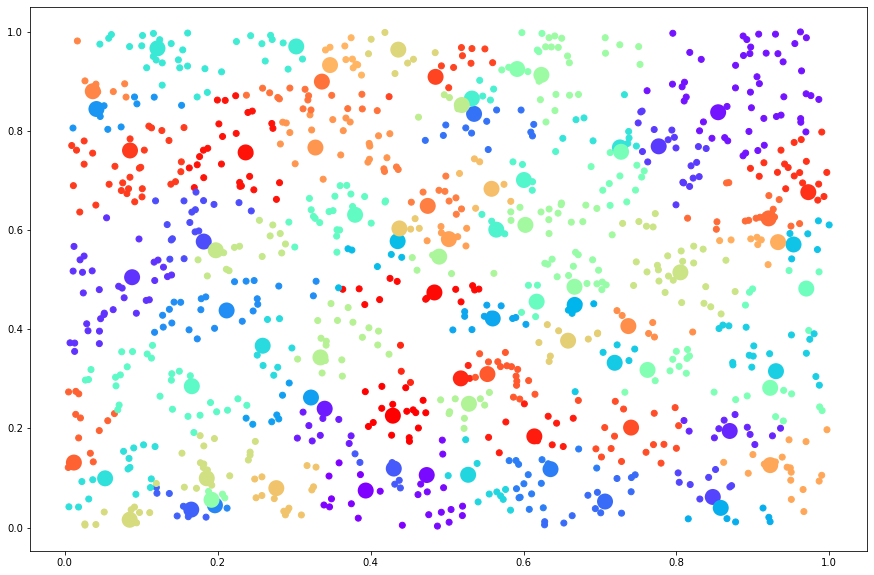

In [13]:
plt.figure(figsize=(15,10))
plt.scatter(X_test[:, 0], X_test[:, 1], c=pred, cmap='rainbow')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, linewidth=10., cmap='rainbow')

# Real data

In [64]:
print(len(X_train), len(X_tes))

NameError: name 'X_tes' is not defined

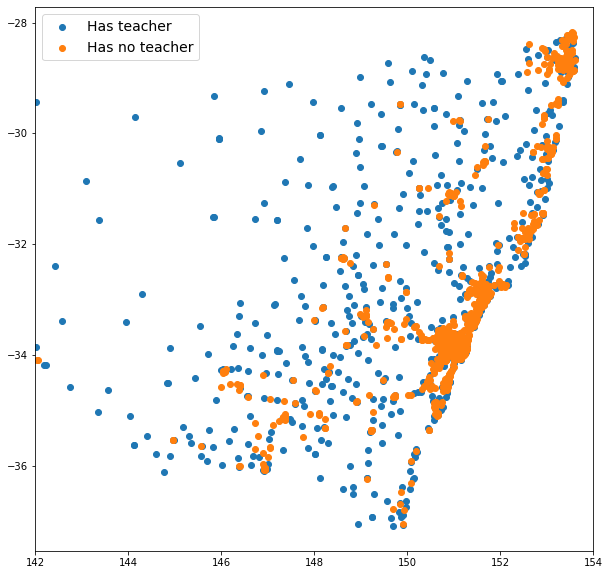

In [84]:
### data = pd.read_csv('Fabi/master_dataset.csv', sep=',')

X_train = np.array(data[['Longitude', 'Latitude', 'latest_year_enrolment_FTE']])
X_train[:,2][np.isnan(X_train[:,2])] = 10

y_train = np.array(data['School_code'])
knn = KNeighborsClassifier(n_neighbors=1, metric=my_dist)
knn.fit(X_train[:,0:2], y_train)

X_test = np.random.uniform(low=[142, -38], high=[154, -28], size=(3000, 2))

pred = knn.predict(X_test)

plt.figure(figsize=(10,10))

has_teacher_mask = np.isin(y_train, pred)
has_teacher = X_train[has_teacher_mask]
has_no_teacher_mask = ~np.isin(y_train, pred)
has_no_teacher = X_train[has_no_teacher_mask]

plt.scatter(has_teacher[:, 0], has_teacher[:, 1], label='Has teacher')
plt.scatter(has_no_teacher[:, 0], has_no_teacher[:, 1], label='Has no teacher')
plt.xlim([142, 154])
plt.legend(fontsize=14)

## New approach

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
from numba import njit

In [ ]:
data = pd.read_csv('Fabi/master_dataset.csv', sep=',')
schools = np.array(data[['School_code', 'Longitude', 'Latitude', 'latest_year_enrolment_FTE']])
schools[:,3][np.isnan(schools[:,3])] = 10
capacities = (schools[:,3] / 15).astype(int) + 1
schools = np.c_[schools, capacities]
number_of_teachers = np.zeros(len(schools))
schools = np.c_[schools, number_of_teachers]

teachers = np.random.uniform(low=[142, -38], high=[154, -28], size=(3000, 2))

@njit
def metrik(teacher, school):
    return np.sqrt((teacher[0]-school[1])**2+(teacher[1]-school[2])**2)

def can_apply(school_index, school):
    if capacity[school_index] > school[2]:
        pass
        

preferred_school = np.empty(len(teachers))
assigned_to = -1 * np.ones(len(teachers))


nr_of_teachers = np.zeros(len(schools))
capacity = (schools[:,3] / 15).astype(int)

#capacity = (schools[:,3] / 15).astype(int)
#print(capacity)

@njit
def get_preferred_school(i_teacher, teacher, schools, applied_to):
    
    non_full_schools = schools[schools[:, 5] < schools[:, 4]]
    
    i_min = -1
    _min = 1000000000

    for i_school, school in enumerate(non_full_schools):
        
        if np.count_nonzero(applied_to == i_school) > 0:
            continue
        
        dis = metrik(teacher, school)
        if dis < _min:
            _min = dis
            i_min = i_school

    return i_min

def is_full(school):
    return school[4] <= school[5]

applications = np.ones(shape=(len(teachers), 1)) * -1

applications = {}

for i in range(1):
    for i_teacher, teacher in enumerate(teachers):
        if i_teacher not in applications:
            applications[i_teacher] = np.empty(len(schools))
        
        i_school = get_preferred_school(i_teacher, teacher, schools, applications[i_teacher])
        applications[i_teacher][i_school] = i_school
        #print(len(assigned_to[assigned_to == -1]))

        school = schools[i_school]
        if not is_full(school):
            assigned_to[i_teacher] = i_school
            school[5] += 1

        

print(len(assigned_to[assigned_to == -1])) 

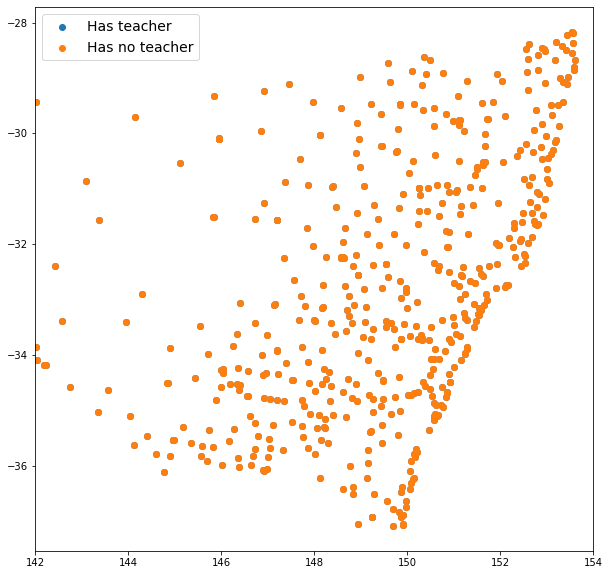

In [190]:
school_indices = np.arange(len(schools))

plt.figure(figsize=(10,10))

has_teacher_mask = np.isin(school_indices, assigned_to)
has_teacher = schools[has_teacher_mask]
has_no_teacher_mask = ~np.isin(school_indices, assigned_to)
has_no_teacher = schools[has_teacher_mask]

plt.scatter(has_teacher[:, 1], has_teacher[:, 2], label='Has teacher')
plt.scatter(has_no_teacher[:, 1], has_no_teacher[:, 2], label='Has no teacher')
plt.xlim([142, 154])
plt.legend(fontsize=14)

In [121]:
print(preferred_schools)

[ 531.   191.   270.  ... 1149.2  279.  1215.8]


In [112]:

unique = np.unique(pred, return_counts=True)

student_to_teacher_ratio = X_train[has_teacher_mask, 2] / unique[1]

too_many_teachers = student_to_teacher_ratio < 15


print(student_to_teacher_ratio[student_to_teacher_ratio<15])
#y_train[y_train==unique]

#overfilled_schools = X_train[X_train[:,2] > X_]

[ 6.33333333  5.6         8.25        3.5         9.625       2.28070175
  3.5         8.75        6.14285714  2.75        8.         13.66666667
  6.          7.          5.5        11.          2.66666667 11.33333333
  5.          6.         10.5         1.5         2.33333333  7.2
 11.5         8.          0.5         1.77777778  2.          2.75
  9.16666667  8.         12.          9.5         6.16666667  7.2
 10.          4.          8.33333333  8.75        1.          0.53846154
  1.125       1.75        6.37777778 11.42105263  3.83333333  1.42857143
  2.          1.23809524  6.5        13.5         3.          7.
  4.          7.          9.         14.          3.84615385  3.75
  8.          0.8        13.          6.5         7.5         1.
 13.          4.2         4.75        1.44444444  5.18181818  1.27586207
 11.66666667  2.33333333  2.875      14.          6.7         1.4
  4.          4.83333333  1.18181818  2.          7.          5.6516129
  6.25        0.47826087  4.